# Camera Calibration in OpenCV
_Sudarsanan A K_ <br>
_SC21M063_

## Outline

- OpenCV checkerboard based camera calibration
- Image undistortion

Chessboards are frequently used as test images for camera calibration in computer vision.

- [Chessboard detection](https://en.wikipedia.org/wiki/Chessboard_detection)
- [OpenCV tutorial on camera calibration](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_calib3d/py_calibration/py_calibration.html)

The task here is to use utilities bundled with OpenCV to calibrate a camera from a set of chessboard images.


## Camera calibration using a checkerboard pattern

In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

#### Exercise: loading a sequence of chessboard images

The directory data contains a set of images `left01.jpg`, `left02.jpg`, ... `left14.jpg` that can be used for camera calibration. Use a glob pattern to create a list `images` of all the image filepaths (i.e., a list of strings).

In [2]:
import glob
images = [i for i in glob.glob('imgs/left??.jpg')]
print(images)

['imgs\\left01.jpg', 'imgs\\left02.jpg', 'imgs\\left03.jpg', 'imgs\\left04.jpg', 'imgs\\left05.jpg', 'imgs\\left06.jpg', 'imgs\\left07.jpg', 'imgs\\left08.jpg', 'imgs\\left09.jpg', 'imgs\\left11.jpg', 'imgs\\left12.jpg', 'imgs\\left13.jpg', 'imgs\\left14.jpg']


#### Exercise: examining the first image

Extract the first image filename from the list `images` and convert it to a grayscale image.

- Use [`cv.imread`](https://docs.opencv.org/2.4/modules/highgui/doc/reading_and_writing_images_and_video.html?highlight=imread#imread) to load the image.
- Use [`cv.cvtColor`](https://docs.opencv.org/2.4/modules/imgproc/doc/miscellaneous_transformations.html#cvtcolor) to convert the image from RGB to grayscale.
- Use the identifier img for the original image & `gray` for the grayscale version
- Use `plt.imshow` to visualize the image `gray`.

(480, 640, 3)
(480, 640, 3) (480, 640)


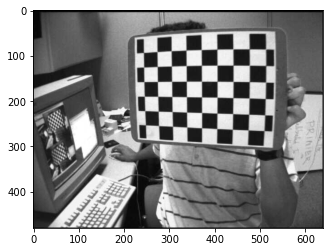

In [3]:
img = cv.imread(images[0])
print(img.shape)
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
print(img.shape, gray.shape)
plt.imshow(gray, cmap='gray')

#### Exercise: examining the first image

- Use the [`findChessboardCorners` function](https://docs.opencv.org/2.4/modules/calib3d/doc/camera_calibration_and_3d_reconstruction.html#findchessboardcorners) built-in to OpenCV to extract the corners from the image `gray`.

    - Assume a pattern of size (9,6) (corresponding to the interior corners to locate in the chessboard). 
    - Assign the output array of corner coordinates to the identifier corners.
- Use NumPy's squeeze function to eliminate singleton dimensions from the array corners.

We'll see later how corner detection is actually done.

In [4]:
# Extract the corners and the return value
retval, corners = cv.findChessboardCorners(image=gray, patternSize=(9,6))
print(corners.shape)
corners = np.squeeze(corners) # Get rid of extraneous singleton dimension
print(corners.shape)
print(corners[:5])  #Examine the first few rows of corners

(54, 1, 2)
(54, 2)
[[244.45415   94.33141 ]
 [274.62177   92.24126 ]
 [305.49387   90.402885]
 [338.36407   88.836266]
 [371.59216   87.98364 ]]


With the image `img` and the array `corners`, we can now produce a figure showing the original image and the image with circles overlaid on the corner coordinates.

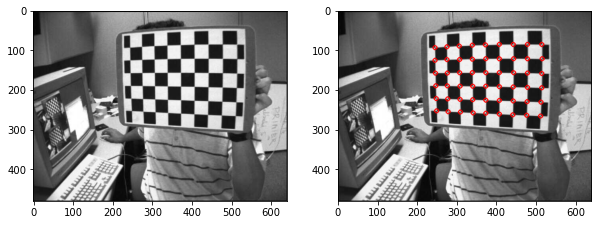

In [5]:
img2 = np.copy(img)  # Make a copy of original img as img2

# Add circles to img2 at each corner identified
for corner in corners:
    coord = (int(corner[0]), int(corner[1]))
    cv.circle(img=img2, center=coord, radius=5, color=(255, 0, 0), thickness=2)

# Produce a figure with the original image img in one subplot and modified image img2 (with the corners added in).
plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(img)
plt.subplot(122)
plt.imshow(img2);

The [`cornerSubPix` function](https://docs.opencv.org/2.4/modules/imgproc/doc/feature_detection.html#cornersubpix) from OpenCV can be used to refine the corners extracted to sub-pixel accuracy. This is based on an iterative technique; as such, one of the inputs `criteria` uses a tuple to bundle a convergence tolerance and a maximum number of iterations.

In [6]:
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001) # Set termination criteria as a tuple.
corners_orig = corners.copy()  # Preserve the original corners for comparison after
corners = cv.cornerSubPix(gray, corners, (11,11), (-1,-1), criteria=criteria) # extract refined corner coordinates.

In [7]:
# Examine how much the corners have shifted (in pixels)
shift = corners - corners_orig
print(shift[:4,:])
print(np.linalg.norm(shift.reshape(-1,1), np.inf))

[[-0.0488739  -0.19455719]
 [-0.22705078 -0.03068542]
 [ 0.0071106  -0.08568573]
 [-0.05487061 -0.04328918]]
0.38919067


Now, generate a figure to compare the original corners to the corrected corners.

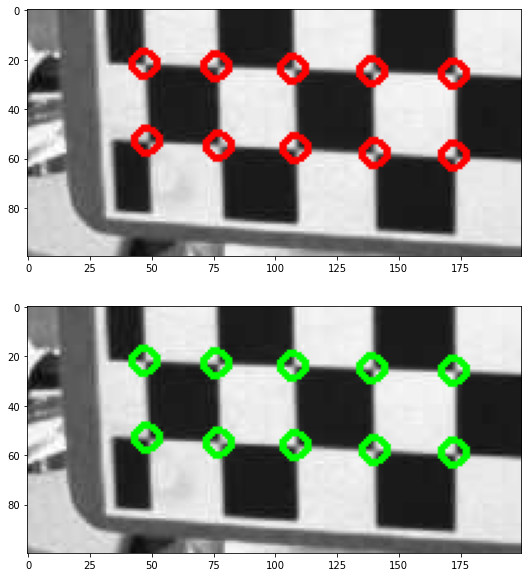

In [8]:
img3 = np.copy(img)

for corner in corners:
    coord = (int(corner[0]), int(corner[1]))
    cv.circle(img=img3, center=coord, radius=5, color=(0, 255, 0), thickness=2)

plt.figure(figsize=(10,10))
plt.subplot(211)
plt.imshow(img2[200:300,200:400,:])
plt.subplot(212)
plt.imshow(img3[200:300,200:400,:]);

The function [drawChessboardCorners](https://docs.opencv.org/2.4/modules/calib3d/doc/camera_calibration_and_3d_reconstruction.html#drawchessboardcorners) generates a new image with circles at the corners detected. The corners are displayed either as red circles if the board was not found, or as colored corners connected with lines if the board was found (as determined by the output argument `retval` from `findChessboardCorners`).

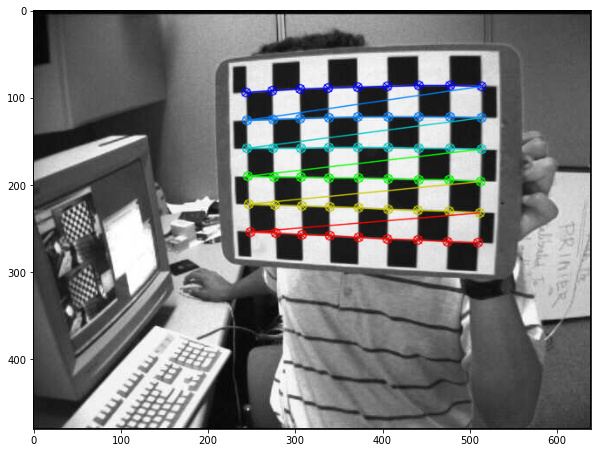

In [9]:
img4 = cv.drawChessboardCorners(img, (9, 6), corners, retval)
plt.figure(figsize=(10,10))
plt.imshow(img4);

Finally, we're going to repeat this process with all the chessboard images to remove distortion effects. First, assume a 3d world coordinate system aligned with the chessboard.

In [10]:
obj_grid = np.zeros((9*6,3), np.float32)
obj_grid[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)
print(obj_grid)

[[0. 0. 0.]
 [1. 0. 0.]
 [2. 0. 0.]
 [3. 0. 0.]
 [4. 0. 0.]
 [5. 0. 0.]
 [6. 0. 0.]
 [7. 0. 0.]
 [8. 0. 0.]
 [0. 1. 0.]
 [1. 1. 0.]
 [2. 1. 0.]
 [3. 1. 0.]
 [4. 1. 0.]
 [5. 1. 0.]
 [6. 1. 0.]
 [7. 1. 0.]
 [8. 1. 0.]
 [0. 2. 0.]
 [1. 2. 0.]
 [2. 2. 0.]
 [3. 2. 0.]
 [4. 2. 0.]
 [5. 2. 0.]
 [6. 2. 0.]
 [7. 2. 0.]
 [8. 2. 0.]
 [0. 3. 0.]
 [1. 3. 0.]
 [2. 3. 0.]
 [3. 3. 0.]
 [4. 3. 0.]
 [5. 3. 0.]
 [6. 3. 0.]
 [7. 3. 0.]
 [8. 3. 0.]
 [0. 4. 0.]
 [1. 4. 0.]
 [2. 4. 0.]
 [3. 4. 0.]
 [4. 4. 0.]
 [5. 4. 0.]
 [6. 4. 0.]
 [7. 4. 0.]
 [8. 4. 0.]
 [0. 5. 0.]
 [1. 5. 0.]
 [2. 5. 0.]
 [3. 5. 0.]
 [4. 5. 0.]
 [5. 5. 0.]
 [6. 5. 0.]
 [7. 5. 0.]
 [8. 5. 0.]]


In [11]:
# Initialize enpty list to accumulate coordinates
obj_points = [] # 3d world coordinates
img_points = [] # 2d image coordinates

In [12]:
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)

for fname in images:
    print('Loading {}'.format(fname))
    img = cv.imread(fname)
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    
    retval, corners = cv.findChessboardCorners(gray, (9,6))
    if retval:
        obj_points.append(obj_grid)        
        corners2 = cv.cornerSubPix(gray, corners, (11,11), (-1,-1), criteria)
        img_points.append(corners2)

Loading imgs\left01.jpg
Loading imgs\left02.jpg
Loading imgs\left03.jpg
Loading imgs\left04.jpg
Loading imgs\left05.jpg
Loading imgs\left06.jpg
Loading imgs\left07.jpg
Loading imgs\left08.jpg
Loading imgs\left09.jpg
Loading imgs\left11.jpg
Loading imgs\left12.jpg
Loading imgs\left13.jpg
Loading imgs\left14.jpg


The accumulated lists of object coordinates and image coordinates can be combined to determine an optimal set of camera calibration parameters. The relevant OpenCV utility here is [`calibrateCamera`](https://docs.opencv.org/2.4/modules/calib3d/doc/camera_calibration_and_3d_reconstruction.html#cv2.calibrateCamera).

In [13]:
retval, mtx, dist, rvecs, tvecs = cv.calibrateCamera(obj_points, img_points, gray.shape[::-1], None, None)

In [14]:
print(retval) # Objective function value
print(mtx)    # Camera matrix
print(dist)   # Distortion coefficients

0.4086955848818589
[[536.07343019   0.         342.37038791]
 [  0.         536.01634475 235.53685635]
 [  0.           0.           1.        ]]
[[-0.26509006 -0.0467439   0.00183301 -0.00031471  0.25231586]]


The function [getOptimalNewCameraMatrix](https://docs.opencv.org/2.4/modules/calib3d/doc/camera_calibration_and_3d_reconstruction.html#cv2.getOptimalNewCameraMatrix) can use the optimized matrix and distortion coefficients to construct a new camera matrix appropriate for a given image. This can be used to remove distortion effects with [undistort](https://docs.opencv.org/2.4/modules/imgproc/doc/geometric_transformations.html#undistort).

In [15]:
img = cv.imread(images[12])
h,w = img.shape[:2]
newcameramtx, roi = cv.getOptimalNewCameraMatrix(mtx, dist, (w,h), 1, (w,h))

In [16]:
# undistort
dst = cv.undistort(img, mtx, dist, None, newcameramtx)

# crop the image
x,y,w,h = roi
dst = dst[y:y+h, x:x+w]

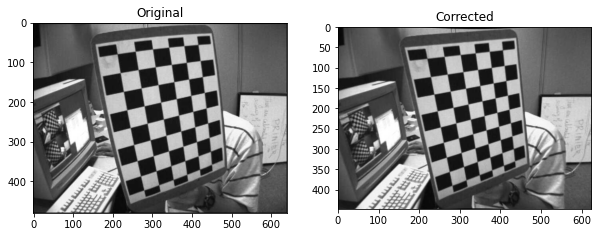

In [17]:
plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(img)
plt.title('Original')
plt.subplot(122)
plt.imshow(dst)
plt.title('Corrected');